## Cargamos los datos

In [13]:
import pandas as pd
irisDataset = pd.read_csv("iris.data", 
                          names=["sepallength","sepalwidth",
                                 "petallength","petalwidth","class"])
irisDataset

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## Gráficas de entrada

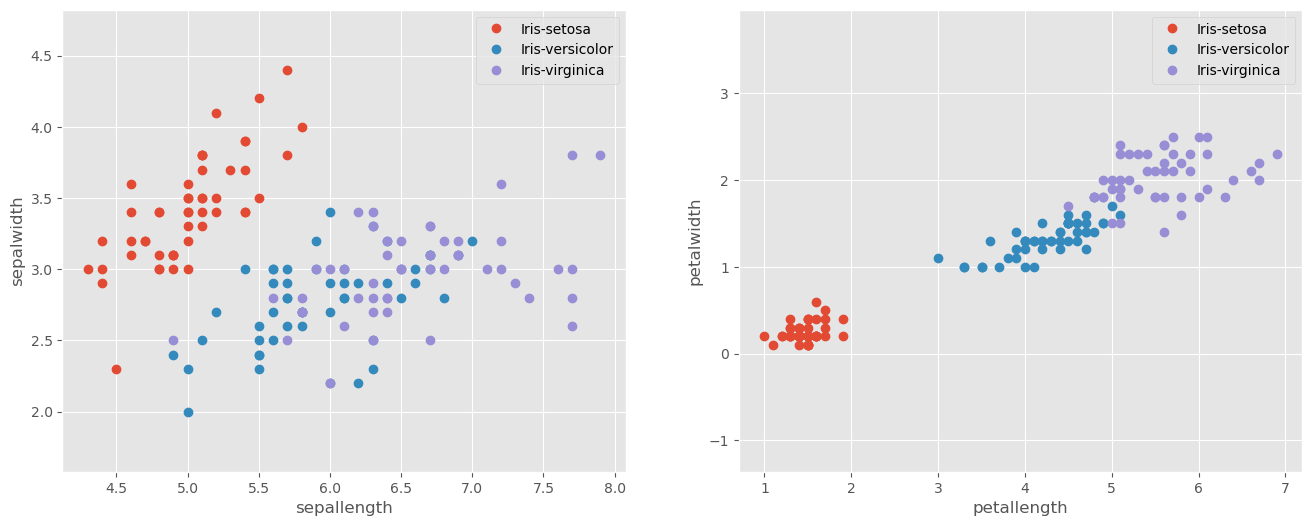

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
nomeClases = irisDataset["class"].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax1.plot(X_plot["sepallength"], X_plot["sepalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel("sepallength")
ax1.set_ylabel("sepalwidth")
ax1.axis('equal')
ax1.legend()

for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax2.plot(X_plot["petallength"], X_plot["petalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel("petallength")
ax2.set_ylabel("petalwidth")
ax2.axis('equal')
ax2.legend()

## Transformaciones

In [15]:
import torch
class StandardScaler:

    def __init__(self, mean=None, std=None, epsilon=1e-7):
     
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

    def __repr__(self):
        return f"mean: {self.mean}, std:{self.std}, epsilon:{self.epsilon}"

In [16]:
from torch.utils.data import Dataset
import pandas as pd
class IrisDataset(Dataset):
    def __init__(self, src_file, root_dir, transform=None):

        irisDataset = pd.read_csv(src_file, names=["sepallength","sepalwidth","petallength","petalwidth","class"])
        X = irisDataset[irisDataset.columns.intersection(["sepallength","sepalwidth","petallength","petalwidth"])]
        Y = irisDataset[irisDataset.columns.intersection(["class"])]

        nomeClases = Y["class"].unique()
        YConversion = pd.DataFrame()

        for nome in nomeClases:
            YConversion[nome] = (Y["class"]==nome).apply(lambda x : 1.0 if x else 0.0)
        y_tensor = torch.as_tensor(YConversion.to_numpy()).type(torch.float32)
        df_dict = dict.fromkeys(X.columns, '')
        X.rename(columns = df_dict)
        s1=X.iloc[:,0:4].values
        x_tensor = torch.tensor(s1)
        scaler = StandardScaler()
        XScalada = scaler.fit_transform(x_tensor).type(torch.float32)
        self.data = torch.cat((XScalada,y_tensor),1)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        preds = self.data[idx, 0:4]
        spcs = self.data[idx, 4:]
        sample = (preds, spcs)
        if self.transform:
            sample = self.transform(sample)
        return sample

## Cargamos los datos

In [17]:
dataset = IrisDataset("iris.data",".")
display(dataset[0])

(tensor([-0.8977,  1.0286, -1.3368, -1.3086]), tensor([1., 0., 0.]))

## Division train y test

In [18]:
from torch.utils.data import random_split

lonxitudeDataset = len(dataset)
tamTrain =int(lonxitudeDataset*0.8)
tamVal = int(lonxitudeDataset*0.2)
print(f"Tam dataset: {lonxitudeDataset} train: {tamTrain} tamVal: {tamVal}")
train_set, val_set = random_split(dataset,[tamTrain,tamVal])
train_ldr = torch.utils.data.DataLoader(train_set, batch_size=2,
    shuffle=True, drop_last=False)
validation_loader =torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)

Tam dataset: 150 train: 120 tamVal: 30


## Creación del modelo

In [19]:
import torch.nn.functional as F
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(in_features=50, out_features=3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

## Instanciamos el modelo

In [20]:
model     = Model(4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
display(model)

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [21]:
entradaProba,dest = next(iter(train_ldr))
print("Entrada:")
display(entradaProba)
print("Desexada:")
display(dest)
saida = model(entradaProba) 
print("Saída:")
display(saida)
loss_fn(saida, dest)

Entrada:


tensor([[ 1.0345, -0.1245,  0.8169,  1.4431],
        [-1.1392, -1.2777,  0.4202,  0.6569]])

Desexada:


tensor([[0., 0., 1.],
        [0., 0., 1.]])

Saída:


tensor([[0.3025, 0.3895, 0.3080],
        [0.2939, 0.4098, 0.2963]], grad_fn=<SoftmaxBackward0>)

tensor(1.1310, grad_fn=<DivBackward1>)

## Función de entrenamiento

In [22]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    # usamos enumerate para saber en que batch imos
    for i, data in enumerate(train_ldr):
        # Every data instance is an input + label pair
        inputs, labels = data
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
    return last_loss

In [23]:
EPOCHS = 100
loss_list     = torch.zeros((EPOCHS,))
accuracy_list = torch.zeros((EPOCHS,))

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Poñemos o modelo en modo entrenamento
    model.train(True)
    avg_loss = train_one_epoch(epoch, None)
    loss_list[epoch] = avg_loss
    # Non se precisan os gradientes para o test
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)

        correct = (torch.argmax(voutputs, dim=0) == vlabels).type(torch.FloatTensor)
        accuracy_list[epoch] += correct.sum()
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {} {}/{}'.format(avg_loss, avg_vloss,accuracy_list[epoch],int(lonxitudeDataset*0.2)))

EPOCH 1:
  batch 10 loss: 1.0949575543403625
  batch 20 loss: 1.0674301385879517
  batch 30 loss: 1.033793330192566
  batch 40 loss: 1.013391798734665
  batch 50 loss: 0.9759045481681824
  batch 60 loss: 0.9139191448688507
LOSS train 0.9139191448688507 valid 0.9107468128204346 26.0/30
EPOCH 2:
  batch 10 loss: 0.9191109240055084
  batch 20 loss: 0.859133642911911
  batch 30 loss: 0.8179907619953155
  batch 40 loss: 0.8056986451148986
  batch 50 loss: 0.8379112958908081
  batch 60 loss: 0.733505642414093
LOSS train 0.733505642414093 valid 0.7854909896850586 28.0/30
EPOCH 3:
  batch 10 loss: 0.7533879160881043
  batch 20 loss: 0.6787831544876098
  batch 30 loss: 0.7216522097587585
  batch 40 loss: 0.7940452814102172
  batch 50 loss: 0.6971848964691162
  batch 60 loss: 0.8006382763385773
LOSS train 0.8006382763385773 valid 0.7326335310935974 33.0/30
EPOCH 4:
  batch 10 loss: 0.7042338728904725
  batch 20 loss: 0.6604285955429077
  batch 30 loss: 0.6408988118171692
  batch 40 loss: 0.80561

In [24]:
torch.save(model.state_dict(), "pesos.pt")